## This Jupyter Notebook is used to do data wrangling and exploratory data analysis

#### Dataset for S&P 500 composites historical price, based on composites list on from wiki up to date 11/25/2020
- all_tickers_data.csv

#### Dataset from SEC(https://www.sec.gov/edgar/searchedgar/companysearch.html) 8-K files, timestamp: 01-01-2005 to 10-31-2020
- sp500_composites_sec_8k.csv

**<font color='teal'> Start by loading the necessary packages and printing out our current working directory just to confirm we are in the correct project directory. </font>**

In [1]:
from bs4 import BeautifulSoup
#import datetime
from datetime import datetime,date
import unicodedata
import requests
import pandas as pd
import numpy as np
from time import sleep
import math
from config import Config
import dateutil.relativedelta
import pandas_market_calendars as mcal
import os
import io
import re
from tqdm import tqdm
import gc
import ast
import glob
from function import *
os.getcwd()

'G:\\Data\\Machine_Learning_Library\\spring_board_data_science\\Capstone\\Capstone2\\src'

In [2]:
df = pd.read_csv("../data/sp500_composites_sec_8k.csv")

In [3]:
df.head()

,ticker,cik,txt_link,doc_name,GICS Sector,GICS Sub Industry,text,release_date,items
0,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000012.txt,Health Care,Health Care,false 0001090872 0001090872 2020-08-18 2020-08...,2020-08-18 16:07:08,"['Item 2.02', 'Item 2.02', 'Item 9.01']"
1,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-160693.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-04 2020-06...,2020-06-04 16:07:06,"['Item 1.01', 'Item 2.03']"
2,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-158521.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-01 2020-06...,2020-06-02 16:33:10,[]
3,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000008.txt,Health Care,Health Care,false 0001090872 0001090872 2020-05-21 2020-05...,2020-05-21 16:06:56,"['Item 2.02', 'Item 2.02', 'Item 9.01']"
4,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001564590-20-017459.txt,Health Care,Health Care,false 0001090872 0001090872 2020-04-17 2020-04...,2020-04-20 16:05:35,"['Item 1.01', 'Item 5.07', 'Item 9.01']"


#### Keep the unique document name

In [4]:
df = df.drop_duplicates(subset="doc_name")
df.shape

(108347, 9)

#### Check the length of text

In [5]:
df.text.str.len().describe()

count    1.082410e+05
mean     9.815021e+03
std      2.386960e+05
min      3.000000e+00
25%      1.782000e+03
50%      2.493000e+03
75%      3.960000e+03
max      6.306556e+07
Name: text, dtype: float64

In [6]:
x = df.text.str.len()
len(x[x>=60000])

893

#### Restricted length of text no more than 60,000

In [7]:
df = df[df.text.str.len()<=60000]

### Data Wrangling - Text PreProcessing
1. Remove extra whitespace
2. Tokenize
3. Remove punctuation, stopwords, convert to lower case
4. Lemmatize
5. Load pre-trained word embeddings

In [2]:
# import spacy
# from nltk.corpus import stopwords
# import string
# import matplotlib.pyplot as plt
# import seaborn as sns

# stop_words = stopwords.words("english")
# nlp = spacy.load("en_core_web_sm")
# nlp.max_length = 76131683

# punctuations = string.punctuation

from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()
import string
punctuations = string.punctuation
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

In [3]:
def cleanup_text(doc, logging=False):
    doc = re.sub( '\s+', ' ', doc ).strip()
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc]
    tokens = [tok for tok in tokens if tok.isalpha()]
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
    tokens_len = len(tokens)
    tokens = ' '.join(tokens)
    return tokens,tokens_len

def nltk_tokenizer(text):
    try:
        tokens = [word for word in word_tokenize(text) if word.isalpha()]
        tokens = list(filter(lambda t: t not in punctuations, tokens))
        tokens = list(filter(lambda t: t.lower() not in stop_words, tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        filtered_tokens = list(
            map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens))
        filtered_tokens = list(filter(lambda t: t not in punctuations, filtered_tokens))
        return filtered_tokens
    except Exception as e:
        raise e

def dask_tokenizer(df):
    df['processed_text'] = df['text'].map(nltk_tokenizer)
    df['text_len'] = df['processed_text'].map(lambda x: len(x))
    return df

In [ ]:
pbar = ProgressBar()
pbar.register()
ddata = dd.from_pandas(df, npartitions=20)
df = ddata.map_partitions(dask_tokenizer).compute(scheduler='single-threaded')

In [14]:
df.to_csv("../data/lemmatized_text.csv",index =False, chunksize=1000)

#### load lemmaized text file

In [26]:
df = pd.read_csv("../data/lemmatized_text.csv")
df['release_date']=df['release_date'].map(lambda x: pd.to_datetime(x))
df.head()

,ticker,cik,txt_link,doc_name,GICS Sector,GICS Sub Industry,text,release_date,items,processed_text,text_len
0,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000012.txt,Health Care,Health Care,false 0001090872 0001090872 2020-08-18 2020-08...,2020-08-18 16:07:08,"['Item 2.02', 'Item 2.02', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",375
1,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-160693.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-04 2020-06...,2020-06-04 16:07:06,"['Item 1.01', 'Item 2.03']","['false', 'united', 'state', 'security', 'exch...",469
2,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-158521.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-01 2020-06...,2020-06-02 16:33:10,[],"['false', 'united', 'state', 'security', 'exch...",321
3,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000008.txt,Health Care,Health Care,false 0001090872 0001090872 2020-05-21 2020-05...,2020-05-21 16:06:56,"['Item 2.02', 'Item 2.02', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",375
4,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001564590-20-017459.txt,Health Care,Health Care,false 0001090872 0001090872 2020-04-17 2020-04...,2020-04-20 16:05:35,"['Item 1.01', 'Item 5.07', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",408


In [27]:
df.text_len.describe()

count    107348.000000
mean        288.316457
std         294.555079
min           0.000000
25%         149.000000
50%         202.000000
75%         313.000000
max        5376.000000
Name: text_len, dtype: float64

#### Remove text with length equals to zero

In [28]:
df = df[df.text_len!=0]
df.shape

(107343, 11)

#### Get left 0.05 quantile and right 0.99 quantile length of text

In [29]:
print(df.text_len.quantile(0.05))
print(df.text_len.quantile(0.99))
df = df[(df.text_len>=df.text_len.quantile(0.05)) & (df.text_len<=df.text_len.quantile(0.99))]

99.0
1508.0


**Set the periods for training and trading** <br>
Model set period (total train set) will be 3 years (750 days)  and trading will be 1 year (250 days). <br>
To avoid bias on start time and end time selection, train set will be moved forward by 250 days in a sliding-window approach, resulting in 12 non-overlapping batches to loop over our entire data set from begin of year 2005 until end of year 2020 Oct.

In [4]:
from datetime import datetime,date,timedelta

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, monthrange(year,month)[1])
    return date(year, month, day)

def diff_month(d1, d2):
    return -((d1.year - d2.year) * 12 + d1.month - d2.month)

def add_years(sourcedate, years):
    month = sourcedate.month
    year = sourcedate.year+years
    day = sourcedate.day
    return date(year, month, day)

def diff_year(d1,d2):
    return -((d1.year-d2.year))


#set for training periods
first_period1 = [datetime.strptime(item,'%Y-%m-%d') for item in ['2005-01-01', '2008-01-01', '2009-01-01']]
nrows1 = diff_year(datetime.strptime('2009-01-01','%Y-%m-%d'),datetime.strptime('2021-01-01','%Y-%m-%d'))+1
periods1=[]
for i in range(nrows1):
    periods1.append(list(map(lambda period: add_years(period,i), first_period1)))
    
periods1 = pd.DataFrame(periods1)
periods1.columns = ['train_start','trad_start','trad_end']
periods1 = periods1.apply(pd.to_datetime)
print(periods1.head(),"\n")
print(periods1.tail(),"\n")

  train_start trad_start   trad_end
0  2005-01-01 2008-01-01 2009-01-01
1  2006-01-01 2009-01-01 2010-01-01
2  2007-01-01 2010-01-01 2011-01-01
3  2008-01-01 2011-01-01 2012-01-01
4  2009-01-01 2012-01-01 2013-01-01 

   train_start trad_start   trad_end
8   2013-01-01 2016-01-01 2017-01-01
9   2014-01-01 2017-01-01 2018-01-01
10  2015-01-01 2018-01-01 2019-01-01
11  2016-01-01 2019-01-01 2020-01-01
12  2017-01-01 2020-01-01 2021-01-01 



#### Reset last trad_end as 2020-11-01

In [5]:
periods1.loc[12,'trad_end'] = datetime.strptime('2020-11-01','%Y-%m-%d')
periods1.tail()

,train_start,trad_start,trad_end
8,2013-01-01,2016-01-01,2017-01-01
9,2014-01-01,2017-01-01,2018-01-01
10,2015-01-01,2018-01-01,2019-01-01
11,2016-01-01,2019-01-01,2020-01-01
12,2017-01-01,2020-01-01,2020-11-01


### Exploratory Data Analysis - EDA

#### Text Length for Train Sets

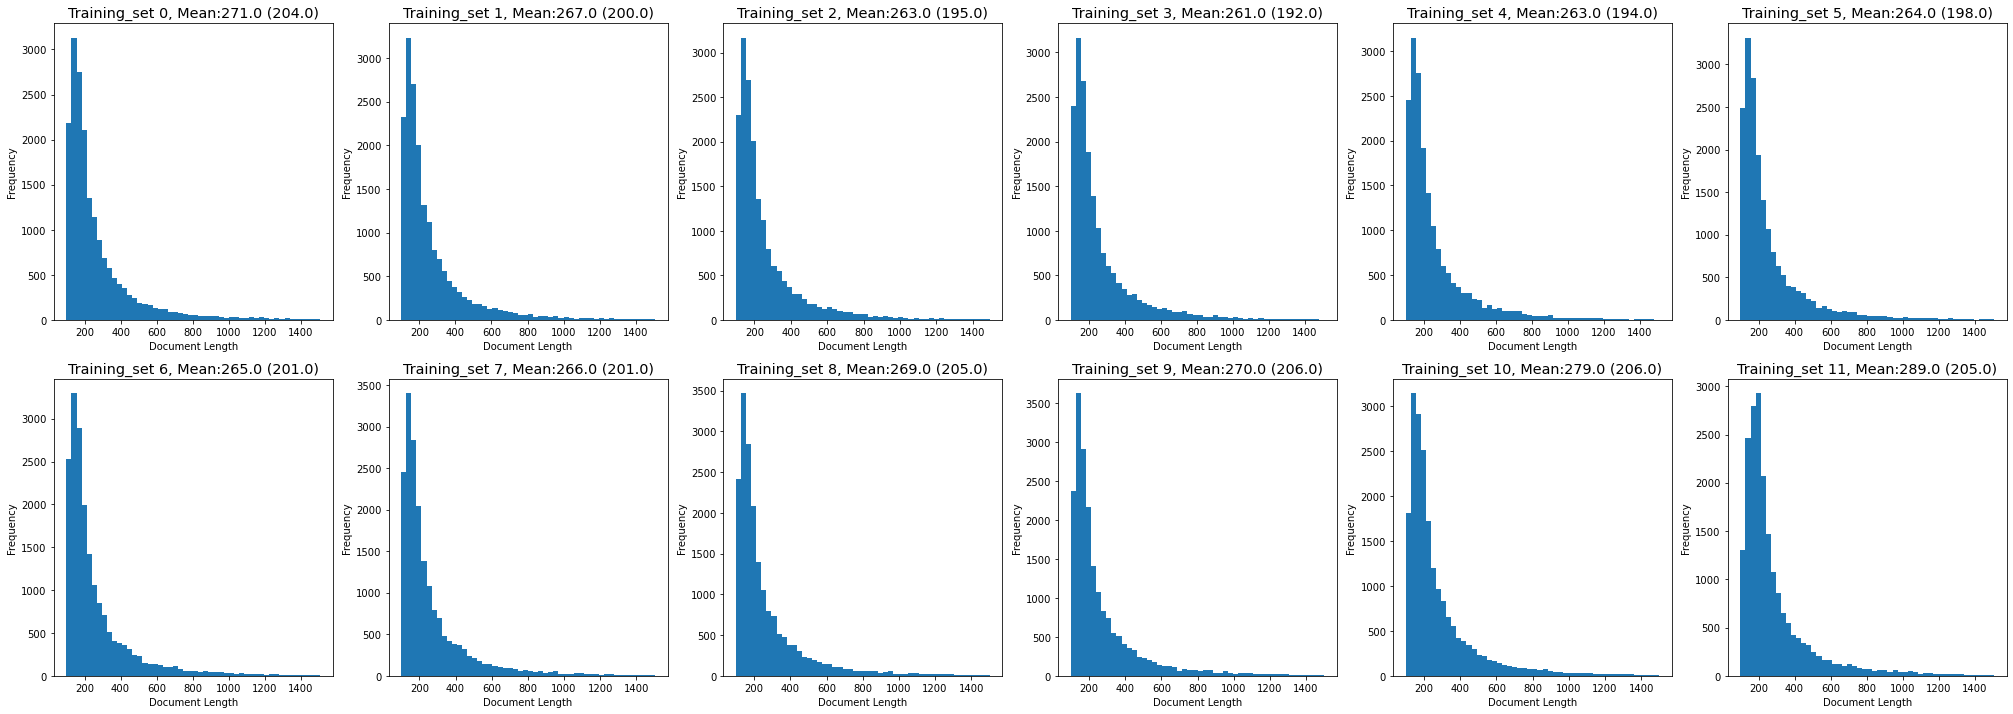

In [10]:
fig, axs = plt.subplots(2,6, figsize=(35, 12), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,0]
    end_date = periods1.iloc[train_ind,1]
    df_cur = df[(df.release_date>=start_date) & (df.release_date<=end_date)]
    axs[int(np.floor(train_ind/6)),train_ind%6].hist(df_cur['text_len'],bins=50)
    axs[int(np.floor(train_ind/6)),train_ind%6].set_title('Training_set '+str(train_ind)+", Mean:" + str(round(np.mean(df_cur['text_len']),0))
                                                          +" ("+str(round(np.std(df_cur['text_len']),0))+")")
    axs[int(np.floor(train_ind/6)),train_ind%6].set_ylabel('Frequency')
    axs[int(np.floor(train_ind/6)),train_ind%6].set_xlabel('Document Length')

#### Text Length for Trade Sets

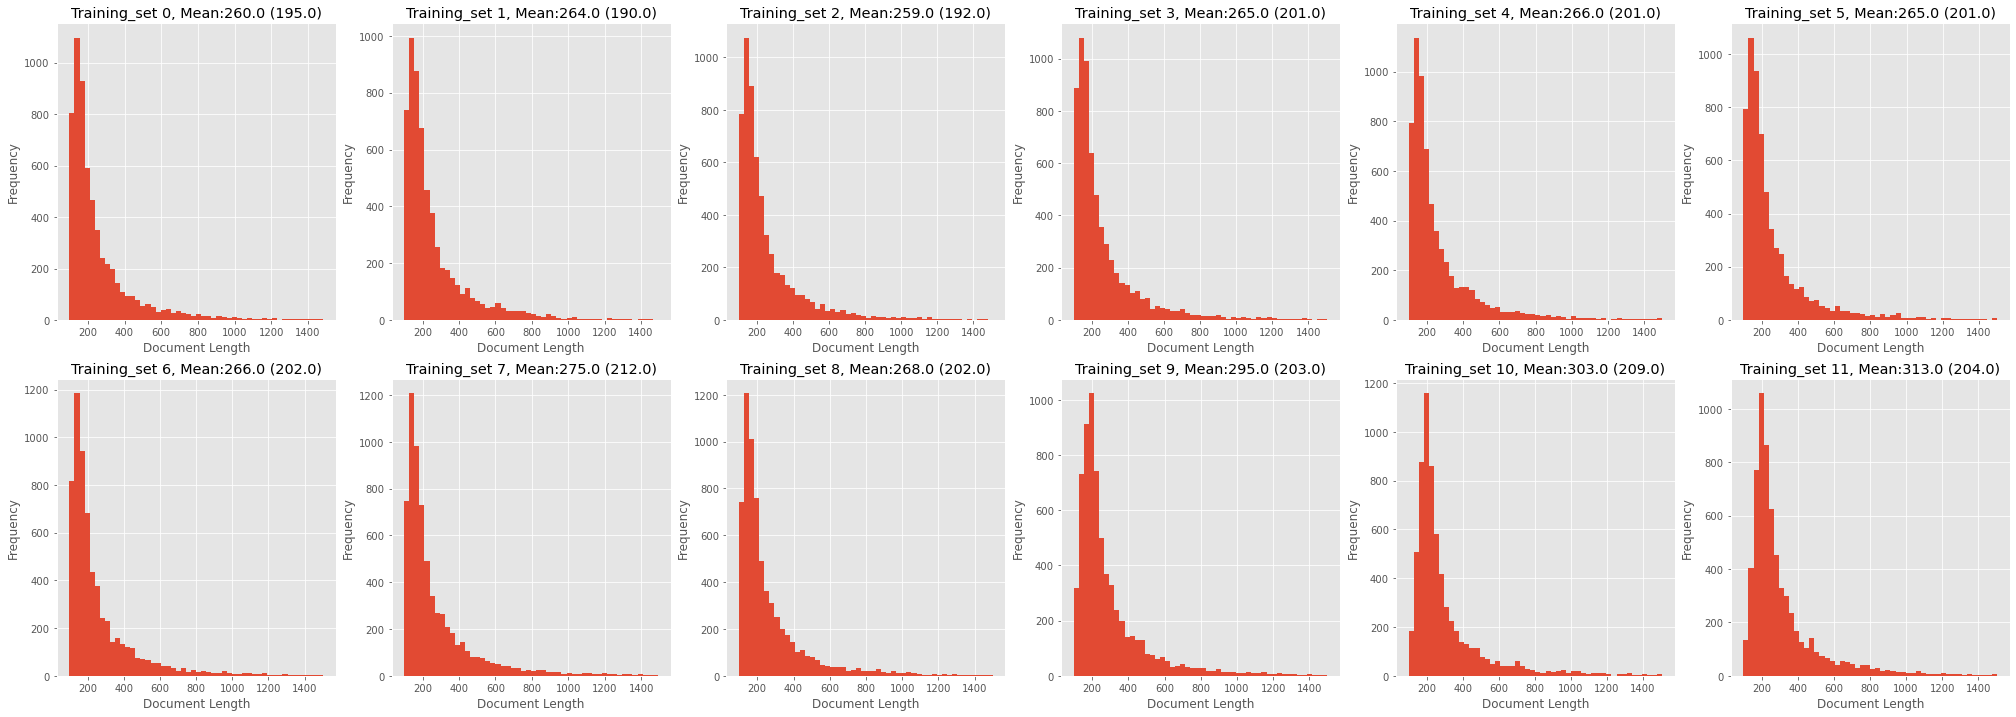

In [11]:
fig, axs = plt.subplots(2,6, figsize=(35, 12), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,1]
    end_date = periods1.iloc[train_ind,2]
    df_cur = df[(df.release_date>=start_date) & (df.release_date<=end_date)]
    axs[int(np.floor(train_ind/6)),train_ind%6].hist(df_cur['text_len'],bins=50)
    axs[int(np.floor(train_ind/6)),train_ind%6].set_title('Training_set '+str(train_ind)+", Mean:" + str(round(np.mean(df_cur['text_len']),0))
                                                          +" ("+str(round(np.std(df_cur['text_len']),0))+")")
    axs[int(np.floor(train_ind/6)),train_ind%6].set_ylabel('Frequency')
    axs[int(np.floor(train_ind/6)),train_ind%6].set_xlabel('Document Length')

#### Counts for GICS Sector 

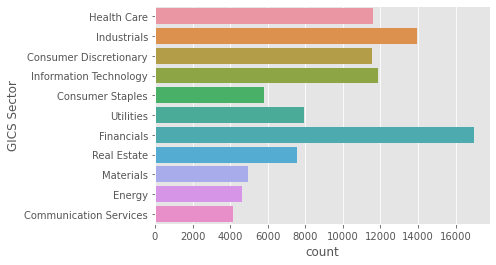

In [72]:
sns.countplot(y=df['GICS Sector'])
#plt.savefig("Graphs/sectors.png",format="png")
plt.show()

#### Release Year

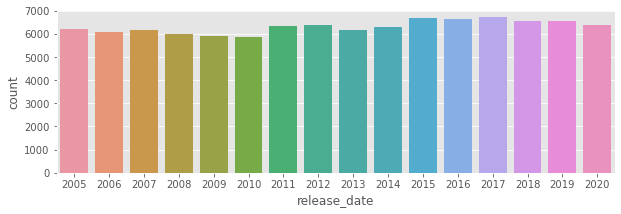

In [80]:
plt.figure(figsize=(10, 3))
sns.countplot(pd.DatetimeIndex(df['release_date']).year)
#plt.savefig("Graphs/year_balances.png",format="png")
plt.show()

#### Load Financial Data

In [14]:
wikidf = pd.read_csv('../data/all_tickers_data.csv',infer_datetime_format=True,parse_dates=['date'])
print(wikidf.shape)
print(wikidf.head())
wikidf.columns = ['ticker','date','Open','High','Low','Close','Volume']

##set date as index, here open, high, low, close are adjusted prices
#wikidf['date'] = wikidf['date'].map(lambda x: pd.to_datetime(x))
wikidf = wikidf.set_index('ticker')
print(wikidf.head())

(3171140, 7)
  Unnamed: 0       date      Open      High       Low     Close     Volume
0        MMM 1990-01-02  8.320541  8.451573  8.294335  8.438470  1496000.0
1        MMM 1990-01-03  8.451575  8.582607  8.438472  8.530194  2631600.0
2        MMM 1990-01-04  8.477783  8.700537  8.477783  8.595712  2538400.0
3        MMM 1990-01-05  8.556400  8.595710  8.451574  8.451574  1825600.0
4        MMM 1990-01-08  8.438472  8.687433  8.438472  8.674330  2164400.0
             date      Open      High       Low     Close     Volume
ticker                                                              
MMM    1990-01-02  8.320541  8.451573  8.294335  8.438470  1496000.0
MMM    1990-01-03  8.451575  8.582607  8.438472  8.530194  2631600.0
MMM    1990-01-04  8.477783  8.700537  8.477783  8.595712  2538400.0
MMM    1990-01-05  8.556400  8.595710  8.451574  8.451574  1825600.0
MMM    1990-01-08  8.438472  8.687433  8.438472  8.674330  2164400.0


Save financial data

In [15]:
#wikidf = wikidf[wikidf.date>='2003-01-01']
wikidf.to_csv('../data/all_tickers_data2.csv')

In [16]:
wikidf = pd.read_csv("../data/all_tickers_data2.csv",parse_dates =['date'])
wikidf = wikidf.set_index('ticker')

In [17]:
print(wikidf.shape)
wikidf.head()

(3171140, 6)


,date,Open,High,Low,Close,Volume
ticker,,,,,,
MMM,1990-01-02,8.320541,8.451573,8.294335,8.438470,1496000.0
MMM,1990-01-03,8.451575,8.582607,8.438472,8.530194,2631600.0
MMM,1990-01-04,8.477783,8.700537,8.477783,8.595712,2538400.0
MMM,1990-01-05,8.556400,8.595710,8.451574,8.451574,1825600.0
MMM,1990-01-08,8.438472,8.687433,8.438472,8.674330,2164400.0


#### Set up and down signal
- Case 1:

$stock_{\text{price_change}}(t) =
            \begin{cases}
            sp_{open}(t)-sp_{close}(t-1) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            sp_{close}(t)-sp_{open}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            sp_{open}(t+1)-sp_{close}(t) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
         \\
          index_{\text{price_change}}(t) =
            \begin{cases}
            ip_{open}(t)-ip_{close}(t-1) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            ip_{close}(t)-ip_{open}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            ip_{open}(t+1)-ip_{close}(t) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
          \\
          $

**Case 1 is meaningful and easy to understand, but not easy to be processed in the trading.**

- Case 2: 

$stock_{\text{price_change}}(t) =
            \begin{cases}
            sp_{close}(t)-sp_{open}(t) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            sp_{open}(t+1)-sp_{close}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            sp_{close}(t+1)-sp_{open}(t+1) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
\\
index_{\text{price_change}}(t) =
            \begin{cases}
            ip_{close}(t)-ip_{open}(t) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            ip_{open}(t+1)-ip_{close}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            ip_{close}(t+1)-ip_{open}(t+1) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
\\
$

**Case 2 tries to detect 8-K (delay) effect on trading day, it can be processed in the trading**

$price_\text{change}(t) = stock_\text{price_change}(t) - index_\text{price_change}(t)$

$signal(t) = 
          \begin{cases}
          \text{up} & \quad \text{if } price_\text{change}(t)>0.01\\
          \text{stay} &\quad \text{if } -0.01<=price_\text{change}(t)<=0.01\\
          \text{down} &\quad \text{if } price_\text{change}(t)<0.01\\
          \end{cases}
          $

### For Case 1

In [47]:
#case 1
import time
fin_data = FinDataExtractor2()
no_parts = 100
#df1 = df.loc[0:1000,:]
#df['price_change'],df['vix'] = zip(*df[['ticker','release_date']].apply(fin_data.get_change,axis=1))
#t0 = time.time()
#df1['price_change'],df1['vix'] = zip(*df1[['ticker','release_date']].apply(fin_data.get_change,axis=1))
#t1 = time.time()
t0 = time.time()
for part_no in range(no_parts,no_parts+1,1):
    print("Running part_no: {}".format(part_no))
    #Load pickle
    #crawled_df = np.array_split(pd.read_pickle("Pickles/doc_links_df.pkl"),no_parts)[part_no-1]
    crawled_df = np.array_split(df,no_parts)[part_no-1]
    crawled_df['price_change'],crawled_df['vix'] = zip(*crawled_df[['ticker','release_date']].apply(fin_data.get_change,axis=1))
    crawled_df['rm_week'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="week",axis=1)
    crawled_df['rm_month'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="month",axis=1)
    crawled_df['rm_qtr'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="quarter",axis=1)
    crawled_df['rm_year'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="year",axis=1)
    crawled_df["signal"] = crawled_df['price_change'].map(lambda x: "stay" if -1<x<1 else ("up" if x>1 else "down"))
    
t1 = time.time()
print("Running time is {}".format(t1-t0))
#print(crawled_df.head())

Running part_no: 100


In [2]:
##Combine all splited files to one file
files = glob.glob("../clean_data/case1/*.csv")

for i in range(0,len(files),1):
    if i ==0:
        this_gen = pd.read_csv(files[i],parse_dates=['release_date'],chunksize=50,index_col=[0])
        this_df = pd.concat([df for df in this_gen])
        df_result = this_df
    else:
        this_gen = pd.read_csv(files[i],parse_dates=['release_date'],chunksize=50,index_col=[0])
        this_df = pd.concat([df for df in this_gen])
        df_result = pd.concat([df_result,this_df],axis=0,ignore_index=True)
    gc.collect()

In [3]:
df_result.head()

,ticker,cik,txt_link,doc_name,GICS Sector,GICS Sub Industry,text,release_date,items,processed_text,text_len,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal
0,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000012.txt,Health Care,Health Care,false 0001090872 0001090872 2020-08-18 2020-08...,2020-08-18 16:07:08,"['Item 2.02', 'Item 2.02', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",375,-2.77,21.51,0.22,3.41,10.87,38.90,down
1,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-160693.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-04 2020-06...,2020-06-04 16:07:06,"['Item 1.01', 'Item 2.03']","['false', 'united', 'state', 'security', 'exch...",469,-0.56,25.81,3.16,15.72,20.20,20.66,stay
2,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-158521.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-01 2020-06...,2020-06-02 16:33:10,[],"['false', 'united', 'state', 'security', 'exch...",321,-0.19,26.84,3.06,13.61,20.32,16.90,stay
3,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000008.txt,Health Care,Health Care,false 0001090872 0001090872 2020-05-21 2020-05...,2020-05-21 16:06:56,"['Item 2.02', 'Item 2.02', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",375,5.28,29.53,-2.03,4.10,13.02,4.03,up
4,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001564590-20-017459.txt,Health Care,Health Care,false 0001090872 0001090872 2020-04-17 2020-04...,2020-04-20 16:05:35,"['Item 1.01', 'Item 5.07', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",408,-0.72,43.83,2.52,10.32,-1.10,-9.18,stay


In [4]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100961 entries, 0 to 100960
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ticker             100961 non-null  object        
 1   cik                100961 non-null  float64       
 2   txt_link           100961 non-null  object        
 3   doc_name           100961 non-null  object        
 4   GICS Sector        100961 non-null  object        
 5   GICS Sub Industry  100961 non-null  object        
 6   text               100961 non-null  object        
 7   release_date       100961 non-null  datetime64[ns]
 8   items              100961 non-null  object        
 9   processed_text     100961 non-null  object        
 10  text_len           100961 non-null  int64         
 11  price_change       99242 non-null   float64       
 12  vix                100805 non-null  float64       
 13  rm_week            99384 non-null   float64 

In [5]:
df_result = df_result[df_result.price_change.notna()]
df_result.shape

(99242, 18)

In [6]:
df_result1 = df_result.fillna(method='ffill',axis=1)
df_result1.info()
del df_result

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99242 entries, 0 to 100960
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ticker             99242 non-null  object        
 1   cik                99242 non-null  object        
 2   txt_link           99242 non-null  object        
 3   doc_name           99242 non-null  object        
 4   GICS Sector        99242 non-null  object        
 5   GICS Sub Industry  99242 non-null  object        
 6   text               99242 non-null  object        
 7   release_date       99242 non-null  datetime64[ns]
 8   items              99242 non-null  object        
 9   processed_text     99242 non-null  object        
 10  text_len           99242 non-null  object        
 11  price_change       99242 non-null  object        
 12  vix                99242 non-null  object        
 13  rm_week            99242 non-null  object        
 14  rm_mo

In [7]:
df_result1.to_csv("../clean_data/lemmatized_text_case1.csv",index=False)

#### Load file

In [8]:
df_result1 = pd.read_csv("../clean_data/lemmatized_text_case1.csv",parse_dates =['release_date'])

#### Histogram of signal for Train Sets

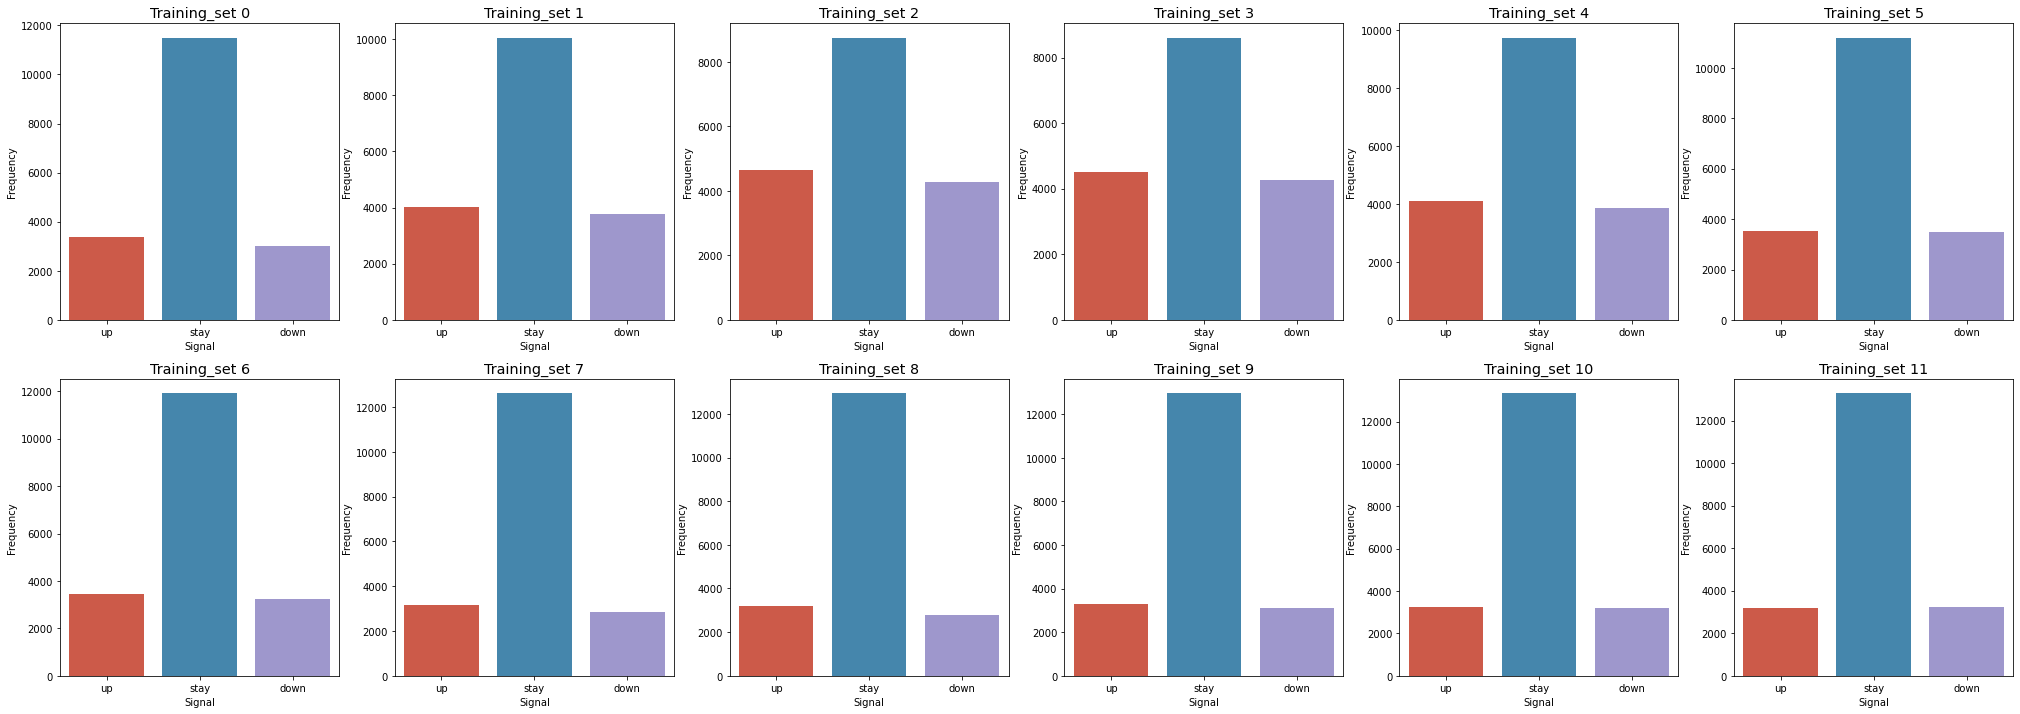

In [44]:
fig, axs = plt.subplots(2,6, figsize=(35, 12), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,0]
    end_date = periods1.iloc[train_ind,1]
    df_cur = df_result1[(df_result1.release_date>=start_date) & (df_result1.release_date<=end_date)]
    
    sns.countplot(df_cur['signal'], ax=axs[int(np.floor(train_ind/6)),train_ind%6],order=['up','stay','down'])
    
    axs[int(np.floor(train_ind/6)),train_ind%6].set_title('Training_set '+str(train_ind))
    axs[int(np.floor(train_ind/6)),train_ind%6].set_ylabel('Frequency')
    axs[int(np.floor(train_ind/6)),train_ind%6].set_xlabel('Signal')

#### Histogram of signal for Trading Sets

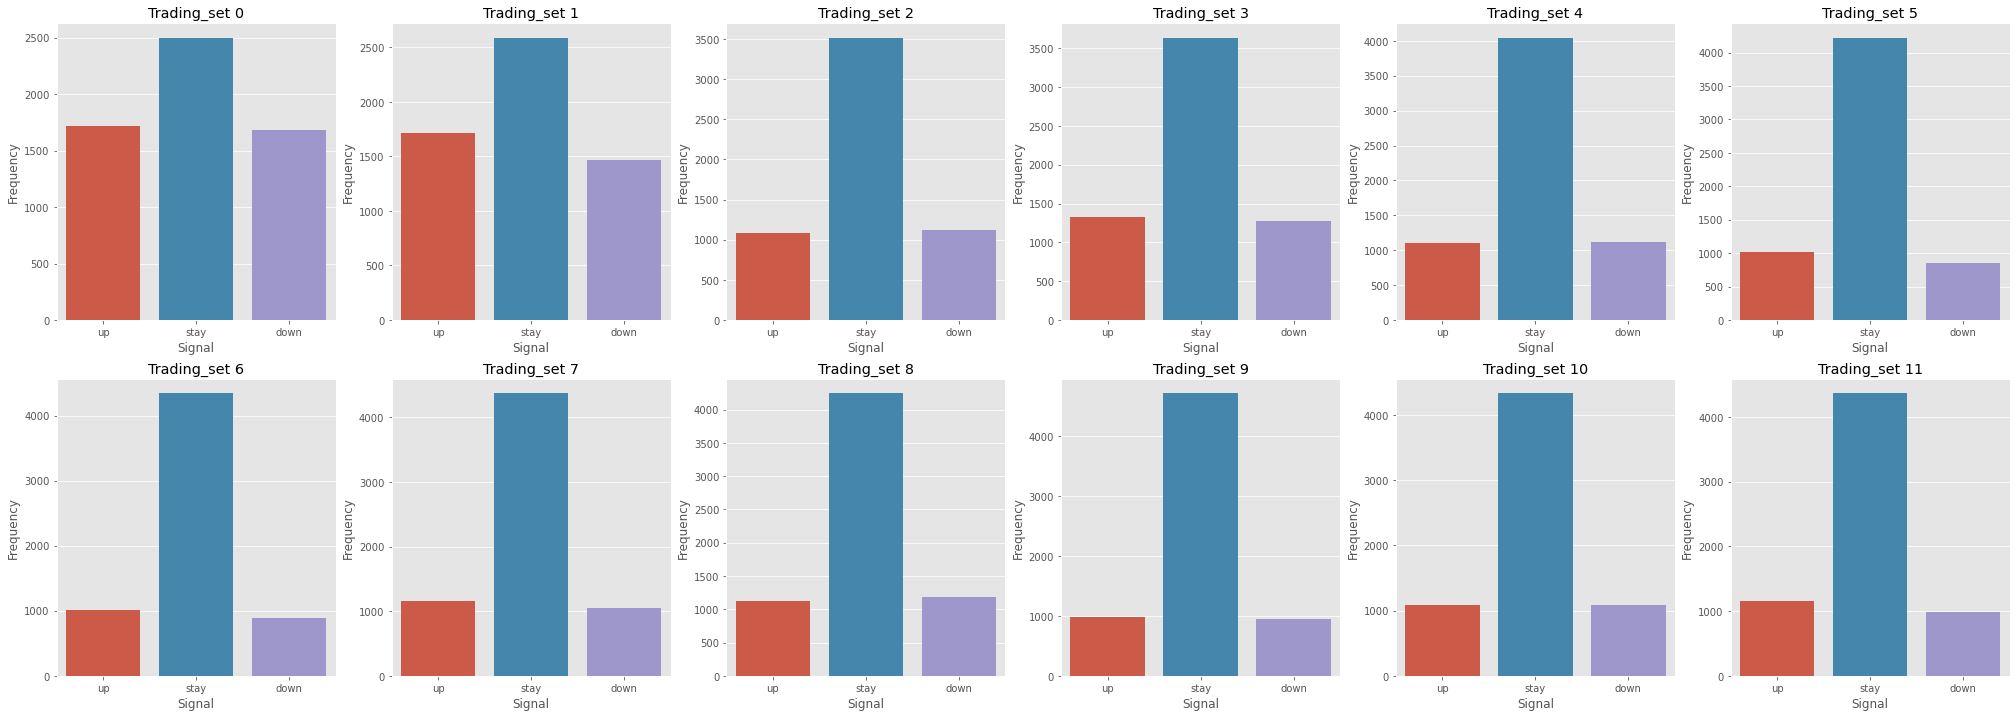

In [45]:
fig, axs = plt.subplots(2,6, figsize=(35, 12), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,1]
    end_date = periods1.iloc[train_ind,2]
    df_cur = df_result1[(df_result1.release_date>=start_date) & (df_result1.release_date<=end_date)]
    
    sns.countplot(df_cur['signal'], ax=axs[int(np.floor(train_ind/6)),train_ind%6],order=['up','stay','down'])
    
    axs[int(np.floor(train_ind/6)),train_ind%6].set_title('Trading_set '+str(train_ind))
    axs[int(np.floor(train_ind/6)),train_ind%6].set_ylabel('Frequency')
    axs[int(np.floor(train_ind/6)),train_ind%6].set_xlabel('Signal')

From previous two plots, we find signals are imbalanced in the train and trade sets

#### Heatmap correlation between new created features vix, rm_week, rm_month, rm_qtr, rm_year

G:\Data\Machine_Learning_Library\learn_others\learn_from_others\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
G:\Data\Machine_Learning_Library\learn_others\learn_from_others\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


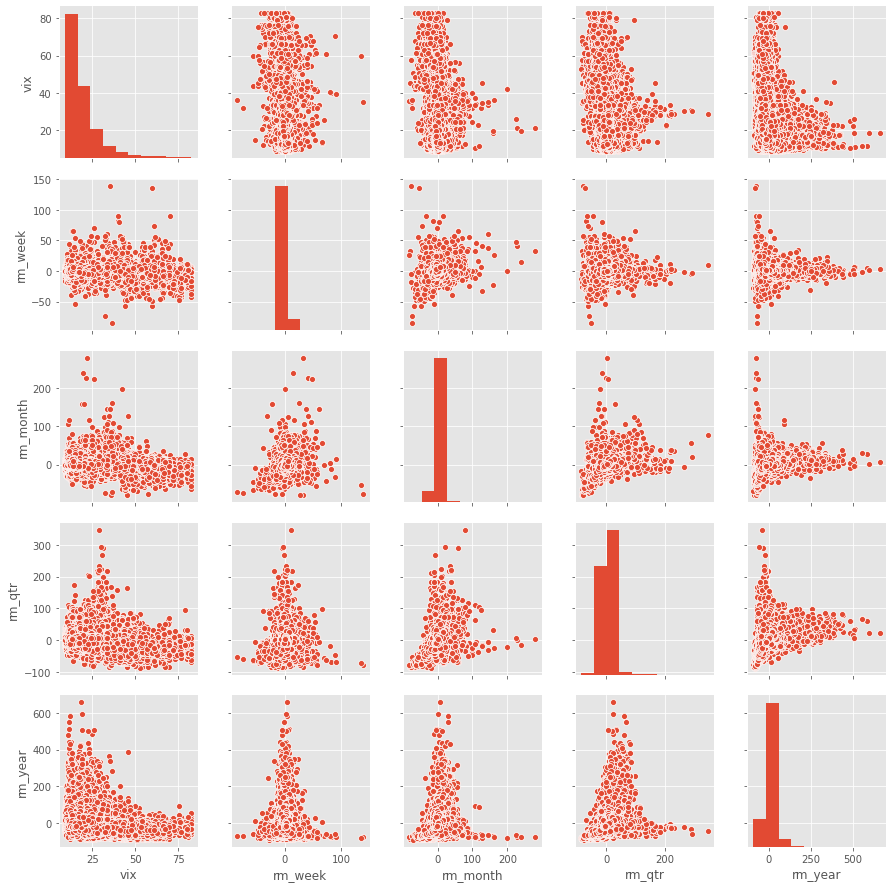

In [46]:
sns.pairplot(df_result1[['vix','rm_week','rm_month','rm_qtr','rm_year']],palette='Set1')
plt.show()

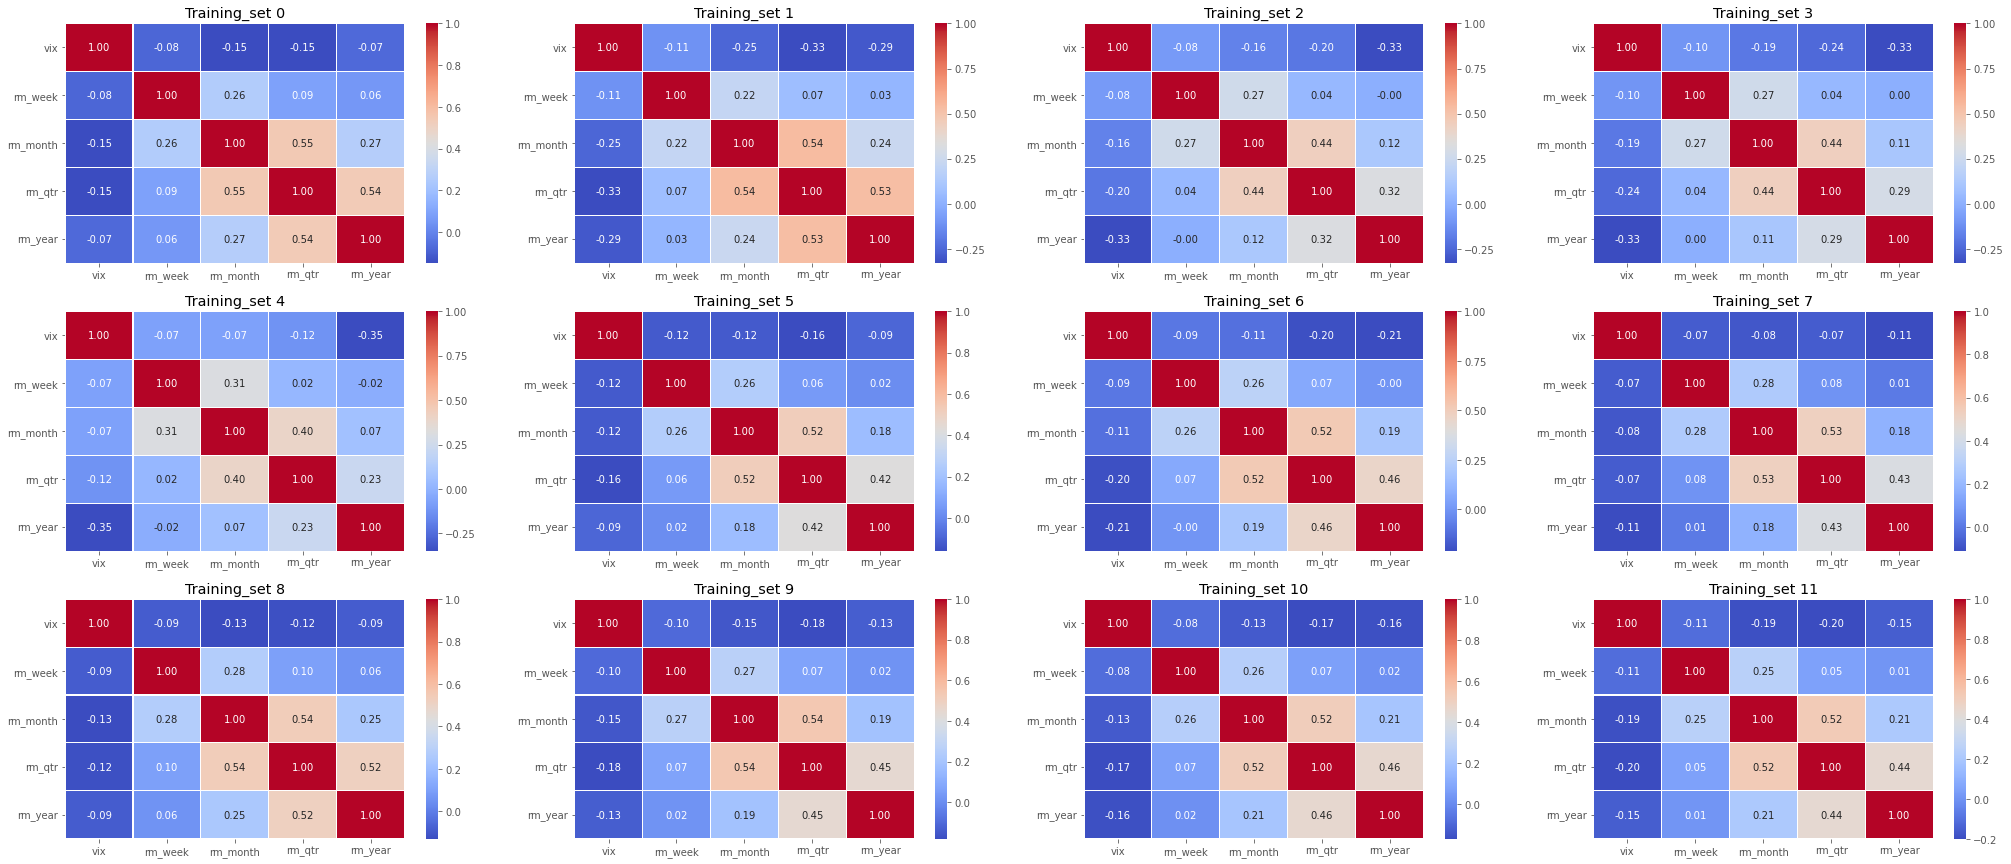

In [47]:
fig, axs = plt.subplots(3,4, figsize=(35, 15), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,0]
    end_date = periods1.iloc[train_ind,1]
    df_cur = df_result1[(df_result1.release_date>=start_date) & (df_result1.release_date<=end_date)]
    
    
    df_feat = df_cur[['vix','rm_week','rm_month','rm_qtr','rm_year']]
    df_corr = df_feat.corr()
    
    #sns.countplot(df_cur['signal'], ax=axs[int(np.floor(train_ind/6)),train_ind%6],order=['up','stay','down'])
    sns.heatmap(round(df_corr,2),annot = True, ax=axs[int(np.floor(train_ind/4)),train_ind%4], cmap='coolwarm',fmt='.2f',linewidths=.05)
    
    axs[int(np.floor(train_ind/4)),train_ind%4].set_title('Training_set '+str(train_ind))
    #axs[int(np.floor(train_ind/4)),train_ind%4].set_ylabel('Frequency')
    #axs[int(np.floor(train_ind/4)),train_ind%4].set_xlabel('Signal')

### For Case 2

In [30]:
#case 2
import time
fin_data = FinDataExtractor3()
no_parts = 100
#df1 = df.loc[0:1000,:]
#df['price_change'],df['vix'] = zip(*df[['ticker','release_date']].apply(fin_data.get_change,axis=1))
#t0 = time.time()
#df1['price_change'],df1['vix'] = zip(*df1[['ticker','release_date']].apply(fin_data.get_change,axis=1))
#t1 = time.time()
t0 = time.time()
for part_no in range(no_parts,no_parts+1,1):
    print("Running part_no: {}".format(part_no))
    #Load pickle
    #crawled_df = np.array_split(pd.read_pickle("Pickles/doc_links_df.pkl"),no_parts)[part_no-1]
    crawled_df = np.array_split(df,no_parts)[part_no-1]
    crawled_df['price_change'],crawled_df['vix'] = zip(*crawled_df[['ticker','release_date']].apply(fin_data.get_change,axis=1))
    crawled_df['rm_week'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="week",axis=1)
    #crawled_df['rm_month'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="month",axis=1)
    #crawled_df['rm_qtr'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="quarter",axis=1)
    #crawled_df['rm_year'] = crawled_df[['ticker','release_date']].apply(fin_data.get_historical_movements,period="year",axis=1)
    #crawled_df["signal"] = crawled_df['price_change'].map(lambda x: "stay" if -1<x<1 else ("up" if x>1 else "down"))
    
t1 = time.time()
print("Running time is {}".format(t1-t0))
#print(crawled_df.head())

Running part_no: 100
Running time is 388.83858132362366


In [10]:
##Combine all splited files to one file
files = glob.glob("../clean_data/case2/*.csv")

for i in range(0,len(files),1):
    if i ==0:
        this_gen = pd.read_csv(files[i],parse_dates=['release_date'],chunksize=50,index_col=[0])
        this_df = pd.concat([df for df in this_gen])
        df_result = this_df
    else:
        this_gen = pd.read_csv(files[i],parse_dates=['release_date'],chunksize=50,index_col=[0])
        this_df = pd.concat([df for df in this_gen])
        df_result = pd.concat([df_result,this_df],axis=0,ignore_index=True)
    gc.collect()
    
df_result.head()

,ticker,cik,txt_link,doc_name,GICS Sector,GICS Sub Industry,text,release_date,items,processed_text,text_len,price_change,vix,rm_week,rm_month,rm_qtr,rm_year,signal
0,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000012.txt,Health Care,Health Care,false 0001090872 0001090872 2020-08-18 2020-08...,2020-08-18 16:07:08,"['Item 2.02', 'Item 2.02', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",375,3.39,22.54,0.22,3.41,10.87,38.90,up
1,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-160693.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-04 2020-06...,2020-06-04 16:07:06,"['Item 1.01', 'Item 2.03']","['false', 'united', 'state', 'security', 'exch...",469,-2.85,24.52,3.16,15.72,20.20,20.66,down
2,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001193125-20-158521.txt,Health Care,Health Care,false 0001090872 0001090872 2020-06-01 2020-06...,2020-06-02 16:33:10,[],"['false', 'united', 'state', 'security', 'exch...",321,-0.95,25.66,3.06,13.61,20.32,16.90,stay
3,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001090872-20-000008.txt,Health Care,Health Care,false 0001090872 0001090872 2020-05-21 2020-05...,2020-05-21 16:06:56,"['Item 2.02', 'Item 2.02', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",375,-0.27,28.16,-2.03,4.10,13.02,4.03,stay
4,A,1090872.0,https://www.sec.gov/Archives/edgar/data/109087...,0001564590-20-017459.txt,Health Care,Health Care,false 0001090872 0001090872 2020-04-17 2020-04...,2020-04-20 16:05:35,"['Item 1.01', 'Item 5.07', 'Item 9.01']","['false', 'united', 'state', 'security', 'exch...",408,-0.92,45.41,2.52,10.32,-1.10,-9.18,stay


In [11]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100961 entries, 0 to 100960
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ticker             100961 non-null  object        
 1   cik                100961 non-null  float64       
 2   txt_link           100961 non-null  object        
 3   doc_name           100961 non-null  object        
 4   GICS Sector        100961 non-null  object        
 5   GICS Sub Industry  100961 non-null  object        
 6   text               100961 non-null  object        
 7   release_date       100961 non-null  datetime64[ns]
 8   items              100961 non-null  object        
 9   processed_text     100961 non-null  object        
 10  text_len           100961 non-null  int64         
 11  price_change       99338 non-null   float64       
 12  vix                100868 non-null  float64       
 13  rm_week            99384 non-null   float64 

In [12]:
df_result = df_result[df_result.price_change.notna()]
df_result.shape

(99338, 18)

In [13]:
df_result2 = df_result.fillna(method='ffill',axis=1)
df_result2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99338 entries, 0 to 100960
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ticker             99338 non-null  object        
 1   cik                99338 non-null  object        
 2   txt_link           99338 non-null  object        
 3   doc_name           99338 non-null  object        
 4   GICS Sector        99338 non-null  object        
 5   GICS Sub Industry  99338 non-null  object        
 6   text               99338 non-null  object        
 7   release_date       99338 non-null  datetime64[ns]
 8   items              99338 non-null  object        
 9   processed_text     99338 non-null  object        
 10  text_len           99338 non-null  object        
 11  price_change       99338 non-null  object        
 12  vix                99338 non-null  object        
 13  rm_week            99338 non-null  object        
 14  rm_mo

In [14]:
df_result2.to_csv("../clean_data/lemmatized_text_case2.csv",index=False)
df_result2 = pd.read_csv("../clean_data/lemmatized_text_case2.csv",parse_dates =['release_date'])

#### Histogram of signal for Train and Trade Sets

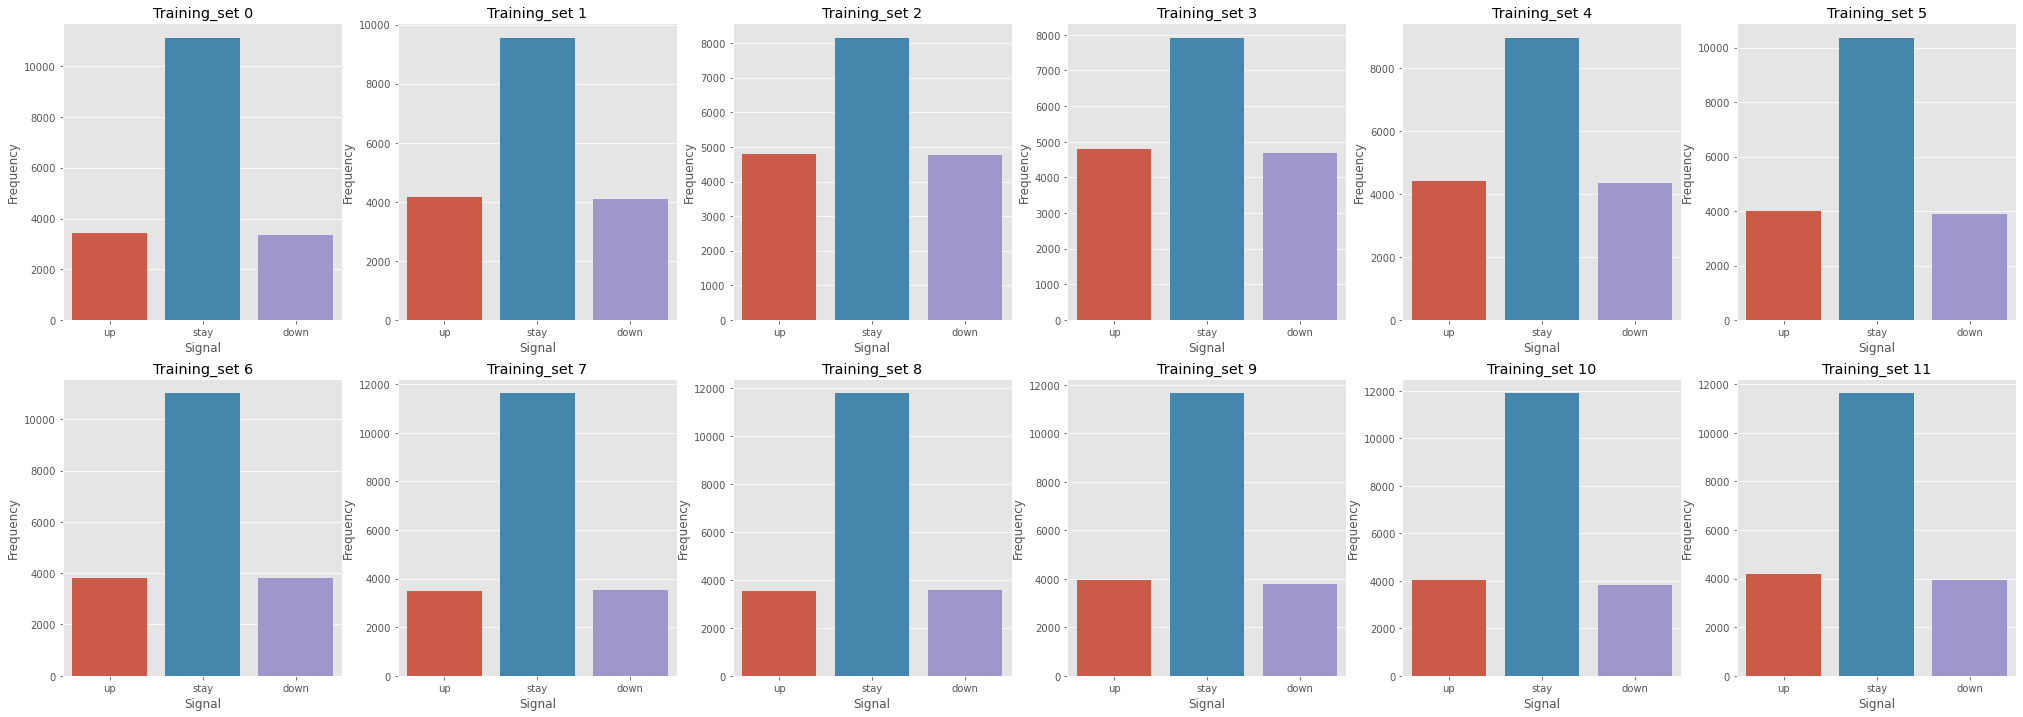

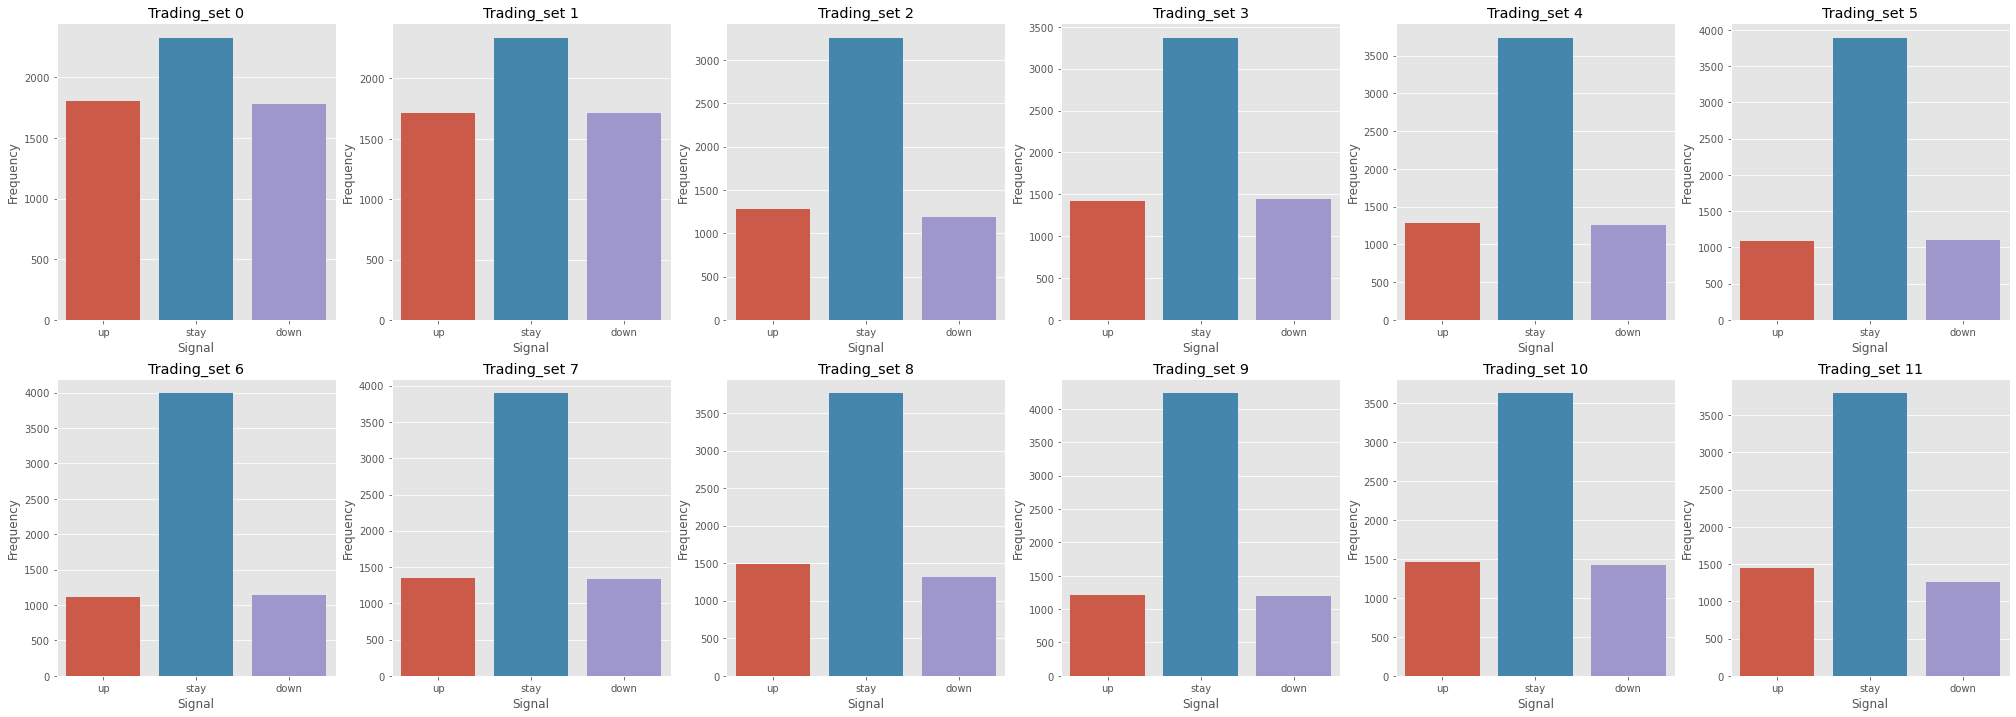

In [58]:
fig, axs = plt.subplots(2,6, figsize=(35, 12), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,0]
    end_date = periods1.iloc[train_ind,1]
    df_cur = df_result1[(df_result1.release_date>=start_date) & (df_result1.release_date<=end_date)]
    
    sns.countplot(df_cur['signal'], ax=axs[int(np.floor(train_ind/6)),train_ind%6],order=['up','stay','down'])
    
    axs[int(np.floor(train_ind/6)),train_ind%6].set_title('Training_set '+str(train_ind))
    axs[int(np.floor(train_ind/6)),train_ind%6].set_ylabel('Frequency')
    axs[int(np.floor(train_ind/6)),train_ind%6].set_xlabel('Signal')

fig, axs = plt.subplots(2,6, figsize=(35, 12), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,1]
    end_date = periods1.iloc[train_ind,2]
    df_cur = df_result1[(df_result1.release_date>=start_date) & (df_result1.release_date<=end_date)]
    
    sns.countplot(df_cur['signal'], ax=axs[int(np.floor(train_ind/6)),train_ind%6],order=['up','stay','down'])
    
    axs[int(np.floor(train_ind/6)),train_ind%6].set_title('Trading_set '+str(train_ind))
    axs[int(np.floor(train_ind/6)),train_ind%6].set_ylabel('Frequency')
    axs[int(np.floor(train_ind/6)),train_ind%6].set_xlabel('Signal')

#### heatmap correlation

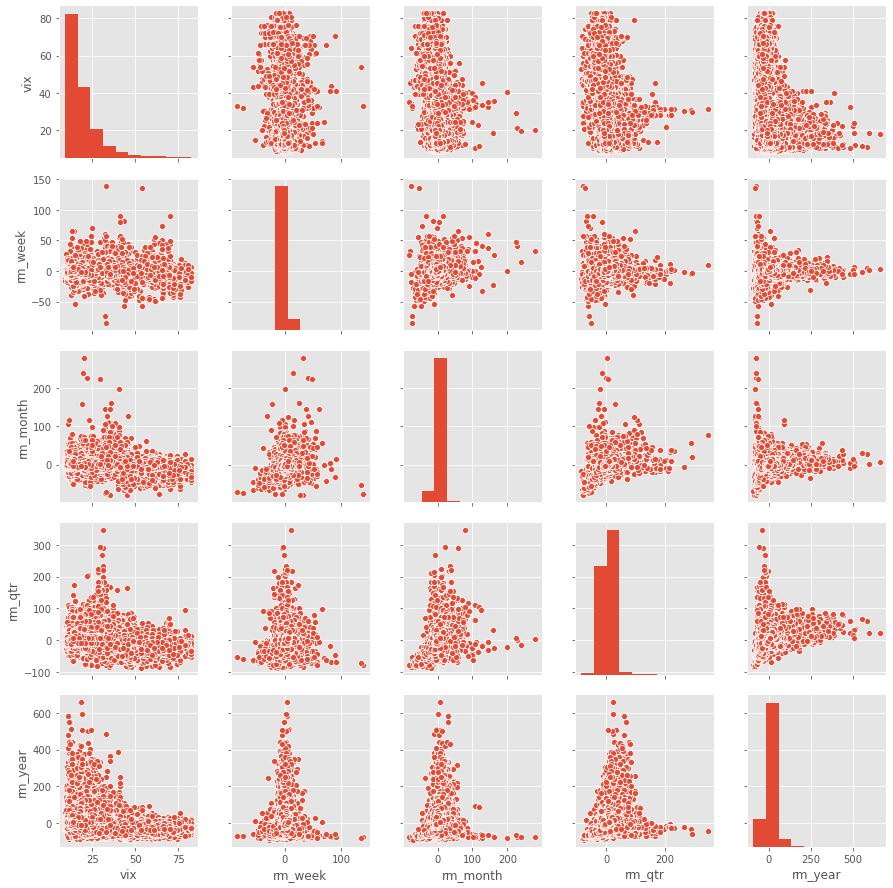

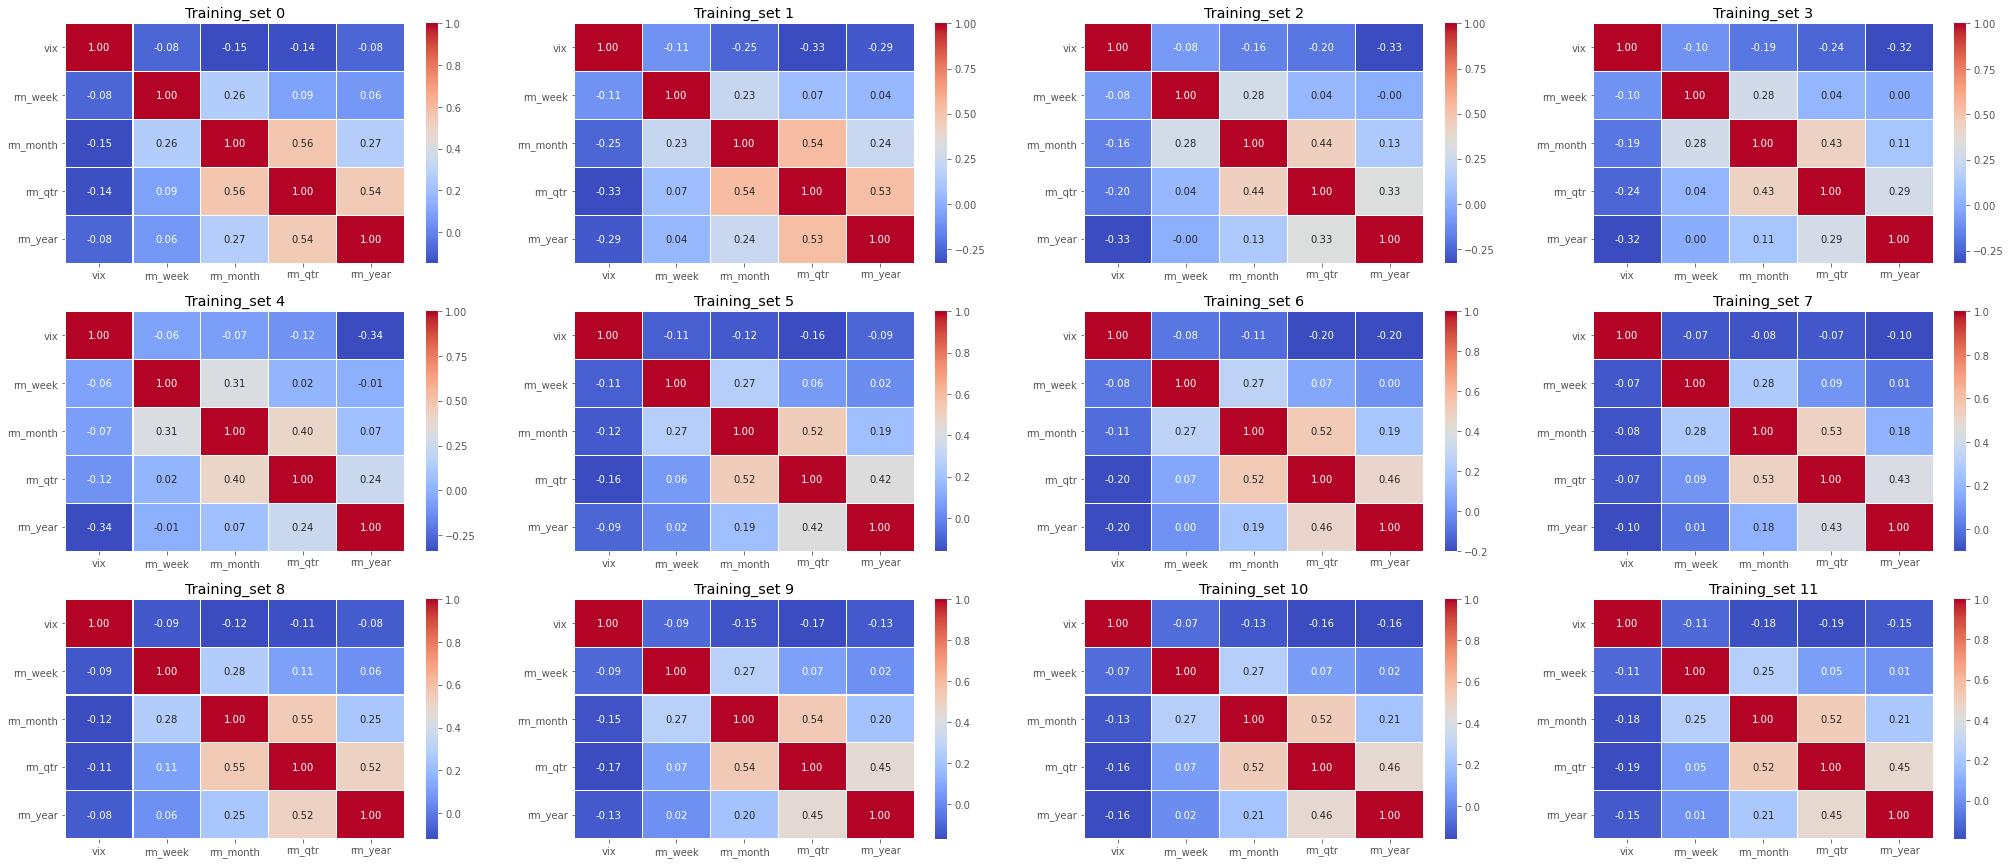

In [59]:
sns.pairplot(df_result1[['vix','rm_week','rm_month','rm_qtr','rm_year']],palette='Set1')
plt.show()

fig, axs = plt.subplots(3,4, figsize=(35, 15), facecolor='w', edgecolor='k')
plt.style.use("ggplot")
for train_ind in range(12):
    start_date = periods1.iloc[train_ind,0]
    end_date = periods1.iloc[train_ind,1]
    df_cur = df_result1[(df_result1.release_date>=start_date) & (df_result1.release_date<=end_date)]
    
    df_feat = df_cur[['vix','rm_week','rm_month','rm_qtr','rm_year']]
    df_corr = df_feat.corr()
   
    sns.heatmap(round(df_corr,2),annot = True, ax=axs[int(np.floor(train_ind/4)),train_ind%4], cmap='coolwarm',fmt='.2f',linewidths=.05)
    axs[int(np.floor(train_ind/4)),train_ind%4].set_title('Training_set '+str(train_ind))

#### Check signal correlation between case1 and case2

In [60]:
df1 = pd.read_csv("../clean_data/lemmatized_text_case1.csv",parse_dates =['release_date'])
df2 = pd.read_csv("../clean_data/lemmatized_text_case2.csv",parse_dates =['release_date'])

In [66]:
df = df1.merge(df2, how ='inner',on='txt_link')

In [80]:
np.corrcoef(pd.factorize(df.signal_x)[0],pd.factorize(df.signal_y)[0])

array([[1.        , 0.05634393],
       [0.05634393, 1.        ]])

In [83]:
from scipy import stats
stats.spearmanr(pd.factorize(df.signal_x)[0],pd.factorize(df.signal_y)[0])

SpearmanrResult(correlation=0.033320686170116014, pvalue=8.665660812867375e-26)

No significant correlation between signals in case 1 and case 2.

In [89]:
print("The percentage of signals in case 1 and case 2 are not equal is: {}%".format(round(np.sum(df.signal_x!=df.signal_y)/df.shape[0]*100,2)))

The percentage of signals in case 1 and case 2 are not equal is: 48.62%
